In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("GPU 환경에서 실행됩니다.")
else:
    print("GPU가 감지되지 않습니다 CPU 환경에서 실행됩니다.")

print(f"tf version is {tf.__version__}")

GPU가 감지되지 않습니다 CPU 환경에서 실행됩니다.
tf version is 2.18.0


In [2]:
import os 
print("현재 디렉토리", os.getcwd())

현재 디렉토리 c:\Users\yunju\OneDrive\바탕 화면\Repositroy\dacon\건설공사 사고 예방


In [3]:
import os
base_dir = os.getcwd()
csv_path = os.path.join(base_dir,"데이터셋", "train.csv")
train_df = pd.read_csv(csv_path)
train_df.head()

,ID,발생일시,사고인지 시간,날씨,기온,습도,공사종류,연면적,층 정보,인적사고,물적사고,공종,사고객체,작업프로세스,장소,부위,사고원인,재발방지대책 및 향후조치계획
0,TRAIN_00000,2023-12-31 오후 12:44,정규작업 -,맑음,1℃,30%,건축 / 건축물 / 근린생활시설,"4,892.77㎡","지상 14층, 지하 3층",떨어짐(5미터 이상 ~ 10미터 미만),없음,건축 > 철근콘크리트공사,건설자재 > 철근,설치작업,근린생활시설 / 내부,철근 / 고소,"고소작업 중 추락 위험이 있음에도 불구하고, 안전난간대, 안전고리 착용 등 안전장치...",고소작업 시 추락 위험이 있는 부위에 안전장비 설치.
1,TRAIN_00001,2023-12-30 오후 03:35,정규작업 -,맑음,10℃,90%,토목 / 터널 / 철도터널,-,-,끼임,없음,토목 > 터널공사,건설자재 > 볼트,운반작업,철도터널 / 내부,볼트 / 바닥,부주의,재발 방지 대책 마련과 안전교육 실시.
2,TRAIN_00002,2023-12-30 오후 02:30,정규작업 -,맑음,14℃,70%,건축 / 건축물 / 업무시설,"1,994.62㎡","지상 5층, 지하 0층",넘어짐(미끄러짐),없음,건축 > 철근콘크리트공사,기타 > 기타,형틀 및 목공,업무시설 / 내부,기타 / 바닥,3층 슬라브 작업시 이동중 미끄러짐,현장자재 정리와 안전관리 철저를 통한 재발 방지 대책 및 공문 발송을 통한 향후 조...
3,TRAIN_00003,2023-12-30 오후 12:00,휴일근무 -,흐림,12℃,55%,토목 / 하천 / 기타,-,-,기타,전도,토목 > 하천공사,부재 > 교각 기초,조립작업,기타 / 동산교 신축구간,교각 기초 / 바닥,"교각 기초철근 조립 중 강한 바람에 의해 기둥측 주철근이 균형을 잃고 전도되어, 하...","위험성 평가 및 교육을 통해 작업장 내 위험요인과 안전수칙을 근로자에게 전파하고, ..."
4,TRAIN_00004,2023-12-30 오전 10:00,정규작업 -,맑음,0℃,10%,건축 / 건축물 / 공동주택,"59,388.93㎡","지상 27층, 지하 3층",넘어짐(미끄러짐),없음,건축 > 해체 및 철거공사,기타 > 건설폐기물,해체작업,공동주택 / 내부,건설폐기물 / 바닥,근로자의 부주의,자재 정리 작업 시 세부 작업 방법에 대한 교육 실시와 작업 구간 이동 경로 점검 ...


In [4]:
file_path = os.getcwd()
file = os.path.join(file_path, "데이터셋", "test.csv")
test_df = pd.read_csv(file)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23422 entries, 0 to 23421
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               23422 non-null  object
 1   발생일시             23422 non-null  object
 2   사고인지 시간          23422 non-null  object
 3   날씨               23422 non-null  object
 4   기온               23422 non-null  object
 5   습도               23422 non-null  object
 6   공사종류             23422 non-null  object
 7   연면적              23422 non-null  object
 8   층 정보             23422 non-null  object
 9   인적사고             23390 non-null  object
 10  물적사고             21932 non-null  object
 11  공종               23411 non-null  object
 12  사고객체             22735 non-null  object
 13  작업프로세스           23359 non-null  object
 14  장소               23422 non-null  object
 15  부위               23422 non-null  object
 16  사고원인             23359 non-null  object
 17  재발방지대책 및 향후조치계획  23422 non-null

In [6]:
train_df["사고인지 시간"].unique()

array(['정규작업 -', '휴일근무 -', '연장근무 -', '기타 -', '식사ㆍ휴식 등 -', '작업 전 -',
       '출ㆍ퇴근 등 -', '불류불능 -', '기타 - 2020-07-15 오전 11:00',
       '정규작업 - 2020-07-13 오후 01:00', '정규작업 - 2020-07-10 오후 01:20',
       '정규작업 - 2020-07-10 오후 03:00', '기타 - 2020-07-10 오전 09:05',
       '정규작업 - 2020-07-10 오후 04:17', '정규작업 - 2020-07-10 오전 10:00',
       '정규작업 - 2020-07-08 오후 04:30', '정규작업 - 2020-07-08 오후 01:00',
       '정규작업 - 2020-07-08 오후 03:00', '정규작업 - 2020-07-07 오후 01:00',
       '정규작업 - 2020-07-07 오전 10:45', '정규작업 - 2020-07-07 오전 10:00',
       '정규작업 - 2020-07-07 오전 07:40', '기타 - 2020-07-06 오전 10:10',
       '정규작업 - 2020-07-06 오전 09:20', '휴일근무 - 2020-07-10 오전 11:03',
       '휴일근무 - 2020-07-05 오후 01:30', '기타 - 2020-07-12 오후 03:45',
       '정규작업 - 2020-07-03 오후 03:20', '정규작업 - 2020-07-03 오후 02:00',
       '정규작업 - 2020-07-03 오후 05:09', '식사ㆍ휴식 등 - 2020-07-03 오전 09:00',
       '정규작업 - 2020-07-02 오후 01:40', '정규작업 - 2020-07-01 오후 02:22',
       '정규작업 - 2020-07-01 오후 01:30', '기타 - 2020-07-01 오후 03:20',
       '정

In [7]:
def preprocess(df):
    df = df.copy()
    def 사고인지(x):
        return " ".join(x.split("-")[0:1])
    def 시간(x):
        return "".join(v.replace("정규작업", "").replace('휴일근무', "").replace('연장근무', "").replace('기타', "").strip('식사ㆍ휴식 등').
                        replace('작업 전', "").strip('출ㆍ퇴근 등').replace('불류불능', "").strip("식사ㆍ휴식").strip("-") for v in x.split(" "))
    def 시간1(x):
        return "".join(v.replace("작업전", "") for v in x.split(" "))
    def 시간2(x):
        return "".join(v.replace("오전", " AM ").replace("오후", " PM ") for v in x.split(" "))
    
    def 기온(x):
        return "".join(x.split(" "))[0:2]
    
    def 공사(x):
        return "".join(x.split("/")[0:1])
    
    def 종류(x):
        return "".join(x.split("/")[1:2])
    def 소분류(x):
        return "".join(x.split("/")[2:3])
    
    def 지상(x):
        return "".join(x.split(",")[0:1])
    
    def 지하(x):
        return "".join(x.split(",")[1:2])
    
    def 인적사고(x):
        return "".join(x.split("(")[0:1])
    
    def 원인(x):
        return "".join(x.split("(")[1:2])
    
    def 공종대(x):
        return "".join(x.split(">")[0:1])
    
    def 공종소(x):
        return "".join(x.split(">")[1:2])
    
    def 장소(x):
        return "".join(x.split(" ")[1:2])
    
    
    
        
    
    df["사고인지"] = df["사고인지 시간"].apply(사고인지)
    df["시간"] = df["사고인지 시간"].apply(시간)
    df["시간"] = df["시간"].apply(시간1)
    df["시간"] = df["시간"].apply(시간2)
    df["시간"] = pd.to_datetime(df["시간"], format = "%Y-%m-%d %p %I:%M")

    df["발생일시"] = df["발생일시"].apply(시간2)
    df["발생일시"] = df["발생일시"].apply(lambda x: x.replace("AM 00:", "AM 12:"))
    df["발생일시"] = pd.to_datetime(df["발생일시"], format = "%Y-%m-%d %p %I:%M")

    df["연도"] = df["발생일시"].dt.year
    df["월"] = df["발생일시"].dt.month
    df["일"] = df["발생일시"].dt.day
    df["주"] = df["발생일시"].dt.weekday
    df["시"] = df["발생일시"].dt.hour
    df["분"] = df["발생일시"].dt.minute

    df["기온"] = df["기온"].apply(lambda x: x.replace("℃", " "))
    df["기온"] = df["기온"].apply(lambda x: x.replace(" ", ""))
    df["기온"] = df["기온"].apply(lambda x: x.replace("0-", "-"))
    df.replace("", np.nan, inplace = True)
    df["기온"] = df["기온"].astype(float)
    df["기온"] = df["기온"].where((df["기온"] > -25) & (df["기온"] < 50), np.nan)
    df["기온"] = df["기온"].fillna(df["기온"].median())

    df["습도"] = df["습도"].apply(lambda x: x.replace("%", ""))
    df["습도"] = df["습도"].astype(float)
    df["습도"] = df["습도"].where((df["습도"] < 120), np.nan)
    df["습도"] = df["습도"].fillna(df["습도"].median())

    df["연면적"] = df["연면적"].apply(lambda x: x.replace("㎡", "").replace("-", "").replace(",", ""))
    df["연면적"].replace("", np.nan, inplace = True)
    df["연면적"] = df["연면적"].astype(float)
    df["연면적"] = df["연면적"].where((df["연면적"] > 0) & (df["연면적"] < 7e+5), np.nan)
    df["연면적"] = df["연면적"].fillna(df["연면적"].median())

    df["공사(대분류)"] = df["공사종류"].apply(공사)
    df["공사(중분류)"] = df["공사종류"].apply(종류)
    df["공사(소분류)"] = df["공사종류"].apply(소분류)

    df["층 정보"] = df["층 정보"].apply(lambda x: x.replace("-", "").strip("층").replace("지상", "").replace("지하", ""))
    df["층정보(지상)"] = df["층 정보"].apply(지상)
    df["층정보(지상)"] = df["층정보(지상)"].apply(lambda x: x.replace("층", ""))
    df["층정보(지하)"] = df["층 정보"].apply(지하)

    df.replace("", np.nan, inplace = True)

    df["층정보(지상)"] = df["층정보(지상)"].fillna(0)
    df["층정보(지하)"] = df["층정보(지하)"].fillna(0)
    
    df["인적사고"] = df["인적사고"].fillna("없음")
    df["인적사고(사고)"] = df["인적사고"].apply(인적사고)
    df["인적사고(원인)"] = df["인적사고"].apply(원인)
    df["인적사고(원인)"] = df["인적사고(원인)"].apply(lambda x: x.replace(")", ""))

    df["공종"] = df["공종"].fillna("모름")
    df["공종(대)"] = df["공종"].apply(공종대)
    df["공종(소)"] = df["공종"].apply(공종소)
    
    df["사고객체"] = df["사고객체"].fillna("모름")
    df["사고객체(대)"] = df["사고객체"].apply(공종대)
    df["사고객체(소)"] = df["사고객체"].apply(공종소)

    df["작업프로세스"] = df["작업프로세스"].fillna("기타")

    df["장소(대)"] = df["장소"].apply(공사)
    df["장소(소)"] = df["장소"].apply(종류)

    df["부위(대)"] = df["부위"].apply(공사)
    df["부위(소)"] = df["부위"].apply(종류)

    df["사고원인"] = df["사고원인"].fillna("모름")
    
    return df

train = preprocess(train_df)
test = preprocess(test_df)

train.head()

C:\Users\yunju\AppData\Local\Temp\ipykernel_12984\1338745509.py:80: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["연면적"].replace("", np.nan, inplace = True)
C:\Users\yunju\AppData\Local\Temp\ipykernel_12984\1338745509.py:80: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

,ID,발생일시,사고인지 시간,날씨,기온,습도,공사종류,연면적,층 정보,인적사고,...,인적사고(사고),인적사고(원인),공종(대),공종(소),사고객체(대),사고객체(소),장소(대),장소(소),부위(대),부위(소)
0,TRAIN_00000,2023-12-31 12:44:00,정규작업 -,맑음,1.0,30.0,건축 / 건축물 / 근린생활시설,4892.77,"14층, 3",떨어짐(5미터 이상 ~ 10미터 미만),...,떨어짐,5미터 이상 ~ 10미터 미만,건축,철근콘크리트공사,건설자재,철근,근린생활시설,내부,철근,고소
1,TRAIN_00001,2023-12-30 15:35:00,정규작업 -,맑음,10.0,90.0,토목 / 터널 / 철도터널,30908.00,NaN,끼임,...,끼임,,토목,터널공사,건설자재,볼트,철도터널,내부,볼트,바닥
2,TRAIN_00002,2023-12-30 14:30:00,정규작업 -,맑음,14.0,70.0,건축 / 건축물 / 업무시설,1994.62,"5층, 0",넘어짐(미끄러짐),...,넘어짐,미끄러짐,건축,철근콘크리트공사,기타,기타,업무시설,내부,기타,바닥
3,TRAIN_00003,2023-12-30 12:00:00,휴일근무 -,흐림,12.0,55.0,토목 / 하천 / 기타,30908.00,NaN,기타,...,기타,,토목,하천공사,부재,교각 기초,기타,동산교 신축구간,교각 기초,바닥
4,TRAIN_00004,2023-12-30 10:00:00,정규작업 -,맑음,0.0,10.0,건축 / 건축물 / 공동주택,59388.93,"27층, 3",넘어짐(미끄러짐),...,넘어짐,미끄러짐,건축,해체 및 철거공사,기타,건설폐기물,공동주택,내부,건설폐기물,바닥


In [8]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
from langchain.llms import HuggingFacePipeline

from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch



C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
training_data = train.apply(
    lambda x:{
        "question":(
            f"공사종류 대분류 '{x['공사(대분류)']}', 중분류 '{x['공사(중분류)']}', 소분류 '{x['공사(소분류)']}' 공사 중"
            f"공종 대분류 '{x['공종(대)']}', 소분류 '{x['공종(소)']}' 작업에서"
            f"사고 객체'{x['사고객체(대)']}'(소분류 '{x['사고객체(소)']}') 와 같은 사고가 발생했습니다."
            f"작업 프로세스는 '{x['작업프로세스']}'이며 사고 원인은 '{x['사고원인']}' 입니다."
            f"재발 방지 대책 및 향후 조치 계획은 무엇인가요?"
        ),
        "answer":x["재발방지대책 및 향후조치계획"]
    },
    axis = 1
)

training_data = pd.DataFrame(list(training_data))

In [10]:
testing_data = test.apply(
    lambda x:{
        "question":(
            f"공사종류 대분류 '{x['공사(대분류)']}', 중분류 '{x['공사(중분류)']}', 소분류 '{x['공사(소분류)']}' 공사 중"
            f"공종 대분류 '{x['공종(대)']}', 소분류 '{x['공종(소)']}' 작업에서"
            f"사고 객체'{x['사고객체(대)']}'(소분류 '{x['사고객체(소)']}') 와 같은 사고가 발생했습니다."
            f"작업 프로세스는 '{x['작업프로세스']}'이며 사고 원인은 '{x['사고원인']}' 입니다."
            f"재발 방지 대책 및 향후 조치 계획은 무엇인가요?"
        )
    },
    axis = 1
)

testing_data = pd.DataFrame(list(testing_data))

testing_data.head()

,question
0,"공사종류 대분류 '건축 ', 중분류 ' 건축물 ', 소분류 ' 교정 및 군사시설' ..."
1,"공사종류 대분류 '건축 ', 중분류 ' 건축물 ', 소분류 ' 운수시설' 공사 중공..."
2,"공사종류 대분류 '건축 ', 중분류 ' 건축물 ', 소분류 ' 공동주택' 공사 중공..."
3,"공사종류 대분류 '건축 ', 중분류 ' 건축물 ', 소분류 ' 공동주택' 공사 중공..."
4,"공사종류 대분류 '토목 ', 중분류 ' 교량 ', 소분류 ' 도로교량' 공사 중공종..."


In [11]:
import torch
bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_use_double_quant =True,
    bnb_4bit_quant_type ="nf4",
    bnb_4bit_compute_dtype = torch.bfloat16
)

In [17]:
from transformers import DistilBertTokenizer, DistilBertModel

model = DistilBertModel.from_pretrained('distilbert-base-uncased')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


In [21]:
train_question_prevention = training_data["question"].tolist()
train_answer_prevention = training_data["answer"].tolist()

train_documents = [
    f"Q{q1}\nA: {a1}"
    for q1, a1 in zip(train_question_prevention, train_answer_prevention)
]

embedding_model_name = "jhgan/ko-sbert-nli"
embedding = HuggingFaceEmbeddings(model_name = embedding_model_name)

vector_store = FAISS.from_texts(train_documents, embedding)

retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k":5})

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\yunju\.cache\huggingface\hub\models--jhgan--ko-sbert-nli. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


KeyboardInterrupt: 

In [12]:
#GPU 환경에서만 실행하세요

"""
model_id = "NCSOFT/Llama-VARCO-8b-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config = bnb_config, device_map = "auto")
"""

The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
CUDA is required but not available for bitsandbytes. Please consider installing the multi-platform enabled version of bitsandbytes, which is currently a work in progress. Please check currently supported platforms and installation instructions at https://huggingface.co/docs/bitsandbytes/main/en/installation#multi-backend


RuntimeError: CUDA is required but not available for bitsandbytes. Please consider installing the multi-platform enabled version of bitsandbytes, which is currently a work in progress. Please check currently supported platforms and installation instructions at https://huggingface.co/docs/bitsandbytes/main/en/installation#multi-backend

In [ ]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23422 entries, 0 to 23421
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ID               23422 non-null  object        
 1   발생일시             23422 non-null  datetime64[ns]
 2   사고인지 시간          23422 non-null  object        
 3   날씨               23422 non-null  object        
 4   기온               23422 non-null  float64       
 5   습도               23422 non-null  float64       
 6   공사종류             23422 non-null  object        
 7   연면적              23422 non-null  float64       
 8   층 정보             15222 non-null  object        
 9   인적사고             23422 non-null  object        
 10  물적사고             21932 non-null  object        
 11  공종               23422 non-null  object        
 12  사고객체             23422 non-null  object        
 13  작업프로세스           23422 non-null  object        
 14  장소               23422 non-null  objec

In [ ]:
print(train["연면적"].describe())
print(train["인적사고"].unique())
print(train["부위"].unique())

count     23422.000000
mean      62718.680020
std       98619.064374
min           1.000000
25%       14140.522500
50%       30908.000000
75%       58902.530000
max      698000.000000
Name: 연면적, dtype: float64
['떨어짐(5미터 이상 ~ 10미터 미만)' '끼임' '넘어짐(미끄러짐)' '기타' '물체에 맞음'
 '떨어짐(2미터 이상 ~ 3미터 미만)' '떨어짐(10미터 이상)' '넘어짐(기타)' '부딪힘' '넘어짐(물체에 걸림)'
 '떨어짐(2미터 미만)' '절단, 베임' '깔림' '질병' '떨어짐(3미터 이상 ~ 5미터 미만)' '화상' '분류불능' '찔림'
 '교통사고' '없음' '감전' '떨어짐(분류불능)' '질식']
['철근 / 고소' '볼트 / 바닥' '기타 / 바닥' ... '공구류 / 마그네틱 드릴 비트' '공기압축기 /'
 '자재 / 요추 2,3번 미세골절']


C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  func(*args, **kwargs)
C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


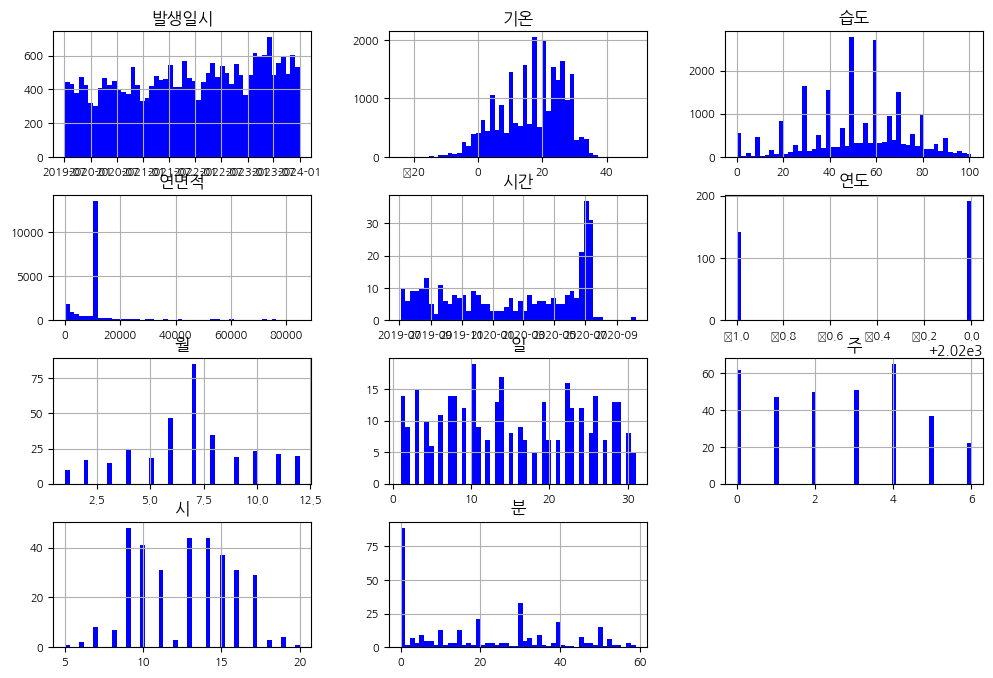

In [ ]:
plt.rc("font", family = "NanumGothic")
train.hist(figsize = (12,8), color = "b", bins = 50, xlabelsize= 8, ylabelsize= 8);

<Axes: xlabel='주', ylabel='연면적'>

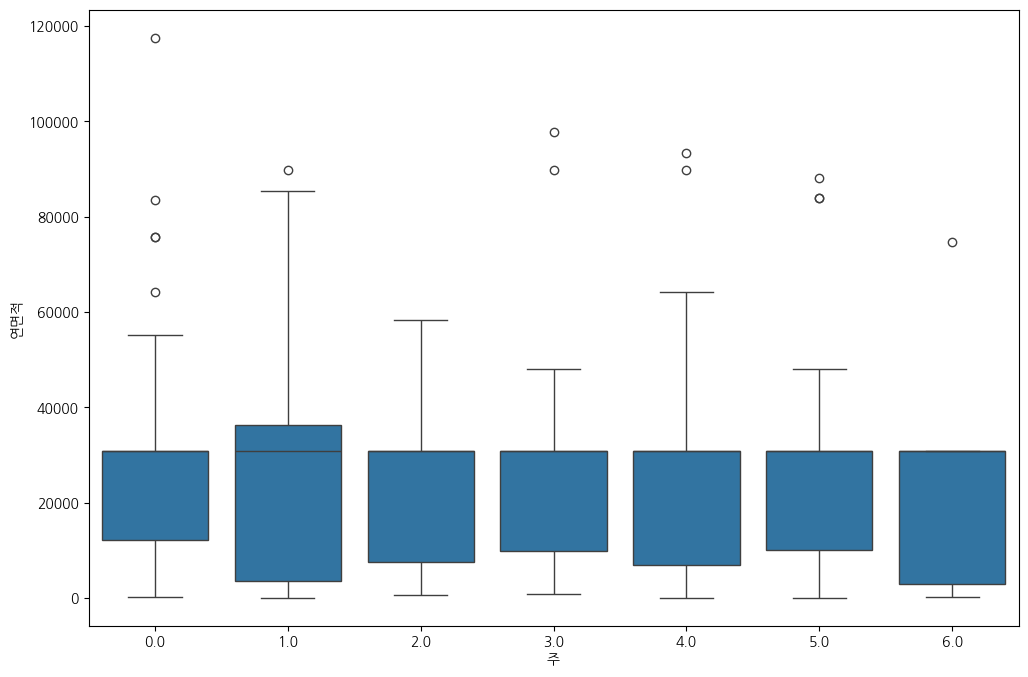

In [ ]:
plt.figure(figsize = (12,8))
sns.boxplot(x = "주", y = "연면적", data = train)